# Deep analysis: VLM→L→V attractor basins (1000 images × 25 iters)

This notebook is designed to help you extract **publishable** plots/tables from an existing run without re-running generation.

**Core “kicker” this notebook builds:** define final-iteration K-Means centroids as *attractors* and measure **basin absorption** over time (how quickly images enter and stay in their final basin).

It also produces:
- step-size dynamics (largest jump is often iter0→iter1: projection onto diffusion manifold)
- drift-to-original dynamics in CLIP space
- within-vs-between basin separation over time
- cluster/basin semantics and retention differences


In [166]:
import os
import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

plt.style.use("seaborn-v0_8-whitegrid")

# Resolve repo root and ensure imports/paths work
REPO_ROOT = Path.cwd().resolve()
if REPO_ROOT.name == "notebooks":
    REPO_ROOT = REPO_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
os.chdir(REPO_ROOT)

RUN_DIR = REPO_ROOT / "experiments/25_iter_1000_img_1.5/20260107_161610_iter25_img1000"
CSV_PATH = RUN_DIR / f"{RUN_DIR.name}_iteration_results.csv"
IMAGES_DIR = RUN_DIR / "images"

# Toggle baseline vs main pipeline inputs
USE_BASELINE = True
BASELINE_METHOD = "random_caption"  # "sd_only", "random_caption", "fixed_caption"
BASELINE_NPZ = RUN_DIR / "baseline_clip_embeddings.npz"

ANALYSIS_ROOT = RUN_DIR / "analysis/kmeans"
ANALYSIS_NAME = None  # set to a specific analysis subfolder; None -> auto/default
if USE_BASELINE and ANALYSIS_NAME is None:
    ANALYSIS_NAME = f"baseline_{BASELINE_METHOD}_k10_nopca"


def resolve_analysis_dir():
    if ANALYSIS_NAME:
        target = ANALYSIS_ROOT / ANALYSIS_NAME
        if not target.exists():
            raise FileNotFoundError(f"Analysis folder not found: {target}")
        return target
    candidates = sorted([p for p in ANALYSIS_ROOT.glob("*") if p.is_dir()], key=lambda p: p.stat().st_mtime)
    if not candidates:
        raise FileNotFoundError(f"No analysis folders found under {ANALYSIS_ROOT}")
    return candidates[-1]


ANALYSIS_DIR = resolve_analysis_dir()
KMEANS_JSON = ANALYSIS_DIR / "kmeans_analysis.json"

FIG_DIR = ANALYSIS_DIR / "plots/paper_figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("CWD:", Path.cwd())
print("RUN_DIR exists:", RUN_DIR.exists())
print("CSV exists:", CSV_PATH.exists())
print("ANALYSIS_DIR:", ANALYSIS_DIR)
print("KMEANS_JSON exists:", KMEANS_JSON.exists())


CWD: /Users/deancasey/Documents/Columbia/vlm-iterative-loss
RUN_DIR exists: True
CSV exists: True
ANALYSIS_DIR: /Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/25_iter_1000_img_1.5/20260107_161610_iter25_img1000/analysis/kmeans/baseline_random_caption_k10_nopca
KMEANS_JSON exists: True


## Load artifacts

In [167]:
df = pd.read_csv(CSV_PATH)
df = df.sort_values(["image_id", "iteration"]).reset_index(drop=True)
df[["iteration", "image_id"]] = df[["iteration", "image_id"]].astype(int)

with open(KMEANS_JSON, "r", encoding="utf-8") as f:
    kmeans_obj = json.load(f)

print("rows:", len(df))
print("images:", df["image_id"].nunique())
print("iterations:", df["iteration"].nunique(), "(min/max)", df["iteration"].min(), df["iteration"].max())
print("kmeans k_values:", kmeans_obj.get("k_values"))
print("kmeans pca_components:", kmeans_obj.get("pca_components"))
print("kmeans pca_scope:", kmeans_obj.get("pca_scope"))
print("kmeans pca_applied:", kmeans_obj.get("pca_applied"))
print("kmeans align_k:", kmeans_obj.get("align_k"))


rows: 25000
images: 1000
iterations: 25 (min/max) 0 24
kmeans k_values: [10]
kmeans pca_components: 0
kmeans pca_scope: none
kmeans pca_applied: False
kmeans align_k: None


Saved grid: /Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/25_iter_1000_img_1.5/20260107_161610_iter25_img1000/analysis/kmeans/baseline_random_caption_k10_nopca/plots/paper_figures/fig0_main_metrics.png


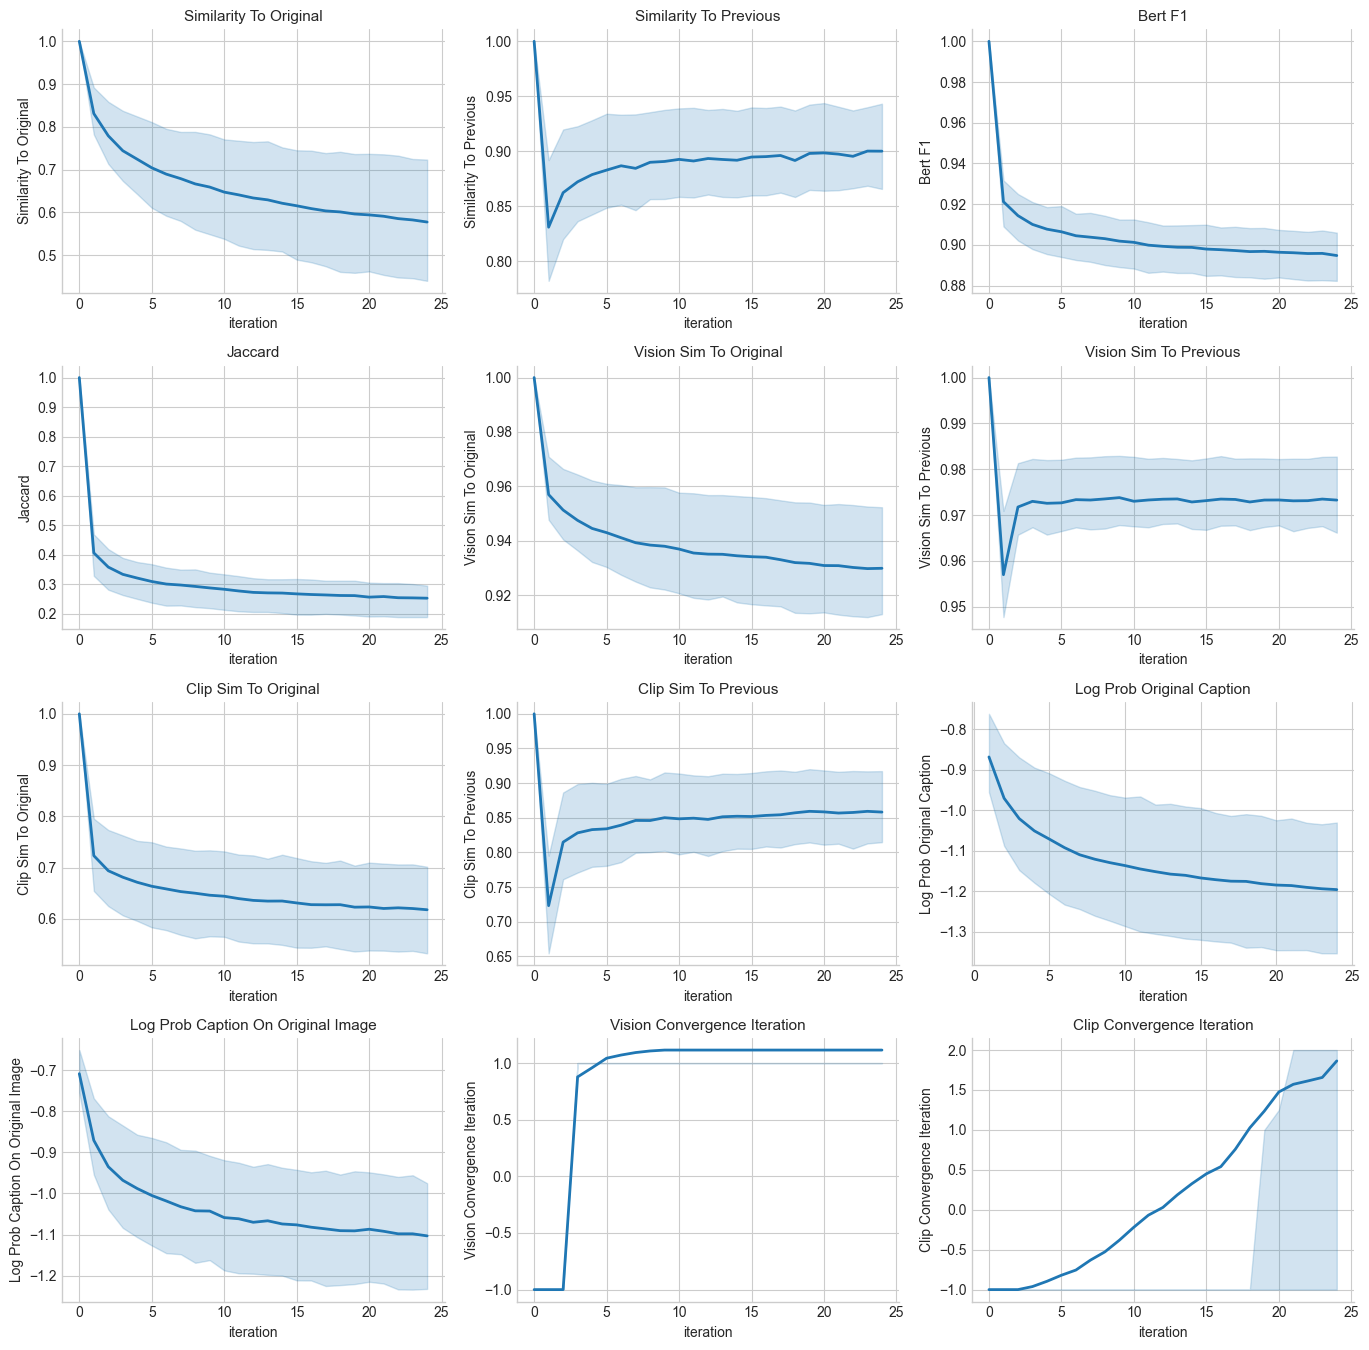

In [168]:
non_numeric = {"image_id","caption","vision_attractor_type","clip_attractor_type","error"}
for c in df.columns:
    if c not in non_numeric:
        df[c] = pd.to_numeric(df[c], errors="coerce")

bool_cols = [
    "vision_currently_converged","vision_ever_converged","vision_diverged_after_convergence","vision_converged",
    "clip_currently_converged","clip_ever_converged","clip_diverged_after_convergence","clip_converged",
]
for c in bool_cols:
    if c in df.columns:
        df[c] = (
            df[c].astype(str).str.lower()
            .map({"1": True, "0": False, "true": True, "false": False})
        )

df["iteration"] = pd.to_numeric(df["iteration"], errors="coerce").astype("Int64")
df = df.dropna(subset=["iteration"]).sort_values(["image_id","iteration"])

exclude_metrics = {"vision_embedding_norm", "clip_embedding_norm", "length_ratio"}

primary_metrics = [
    "similarity_to_original",
    "similarity_to_previous",
    "bert_f1",
    "jaccard",
    "vision_sim_to_original",
    "vision_sim_to_previous",
    "clip_sim_to_original",
    "clip_sim_to_previous",
    "log_prob_original_caption",
    "log_prob_caption_on_original_image",
    "vision_convergence_iteration",
    "clip_convergence_iteration",
]

metric_cols = [
    c for c in df.columns
    if c not in non_numeric | set(bool_cols) | {"iteration"} | exclude_metrics
]

main_metrics = [m for m in primary_metrics if m in metric_cols]
other_metrics = [m for m in metric_cols if m not in main_metrics]
metrics_to_plot = main_metrics + other_metrics

def summarize_metric(metric):
    d = df[["iteration", metric]].dropna()
    if d.empty:
        return None
    g = d.groupby("iteration")[metric]
    return g.mean(), g.quantile(0.25), g.quantile(0.75)

def plot_metric_grid(metrics, ncols=3, base_figsize=(4.6, 3.4), save_path=None):
    summaries = []
    for m in metrics:
        summary = summarize_metric(m)
        if summary:
            summaries.append((m, *summary))

    if not summaries:
        print("No numeric metrics to plot.")
        return None

    nrows = int(np.ceil(len(summaries) / ncols))
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(base_figsize[0] * ncols, base_figsize[1] * nrows),
        sharex=False,
        sharey=False,
    )
    axes = np.array(axes, ndmin=1).ravel()

    for ax, (metric, mean, q25, q75) in zip(axes, summaries):
        ax.plot(mean.index, mean.values, color="C0", lw=2)
        ax.fill_between(mean.index, q25.values, q75.values, color="C0", alpha=0.2)
        label = metric.replace("_", " ").title()
        ax.set_title(label, fontsize=11)
        ax.set_xlabel("iteration")
        ax.set_ylabel(label)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    for ax in axes[len(summaries):]:
        ax.axis("off")

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved grid: {save_path}")
    return fig

grid_path = FIG_DIR / "fig0_main_metrics.png"
grid_fig = plot_metric_grid(metrics_to_plot, ncols=3, base_figsize=(4.6, 3.4), save_path=grid_path)

if grid_fig:
    plt.show()


## Load CLIP embeddings (from checkpoints)

The pipeline saved per-iteration CLIP embeddings for each image (normalized). We'll merge checkpoints into one array per iteration.

In [169]:

def load_all_checkpoints(run_dir: Path):
    ckpts = sorted(run_dir.glob("CLIP_embeddings/checkpoint_imgs*.npz"))
    if not ckpts:
        raise FileNotFoundError(f"No checkpoints in {run_dir}")

    embeddings_by_iter = {}
    image_ids = []
    for ckpt in ckpts:
        data = np.load(ckpt, allow_pickle=True)
        embs = data["embeddings_by_iter"].item()
        for it, arr in embs.items():
            embeddings_by_iter.setdefault(int(it), []).append(np.array(arr))
        image_ids.extend([int(x) for x in data["image_ids"]])

    for it in list(embeddings_by_iter.keys()):
        embeddings_by_iter[it] = np.vstack(embeddings_by_iter[it])

    return embeddings_by_iter, np.array(image_ids, dtype=np.int32)


def load_baseline_embeddings(npz_path: Path, method: str):
    data = np.load(npz_path, allow_pickle=True)
    if method not in data:
        raise ValueError(f"Baseline method '{method}' not found in {npz_path}. Available: {list(data.files)}")
    arr = data[method]
    if arr.dtype == object:
        arr = np.array(arr.tolist(), dtype=np.float32)
    else:
        arr = arr.astype(np.float32, copy=False)
    embeddings_by_iter = {iter_idx: arr[:, iter_idx, :] for iter_idx in range(arr.shape[1])}
    image_ids = np.arange(1, arr.shape[0] + 1, dtype=np.int32)
    return embeddings_by_iter, image_ids


if USE_BASELINE:
    emb_by_iter, image_ids = load_baseline_embeddings(BASELINE_NPZ, BASELINE_METHOD)
    source_desc = f"baseline ({BASELINE_METHOD})"
else:
    emb_by_iter, image_ids = load_all_checkpoints(RUN_DIR)
    source_desc = "main pipeline"

iters = sorted(emb_by_iter.keys())
print(f"Loaded embeddings from {source_desc}; iters: {iters}")
print("emb shape @iter0:", emb_by_iter[iters[0]].shape)
print("image_ids unique:", len(np.unique(image_ids)))

# sanity: embeddings are normalized
norms = np.linalg.norm(emb_by_iter[iters[0]], axis=1)
print("norm mean/std:", norms.mean(), norms.std())


Loaded embeddings from baseline (random_caption); iters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
emb shape @iter0: (100, 768)
image_ids unique: 100
norm mean/std: 0.99996674 0.00023366531


## Helper: simple bootstrap CI (for paper-style error bands)

In [170]:
def bootstrap_mean_ci(values: np.ndarray, n_boot: int = 300, ci: float = 95.0, seed: int = 0):
    """Bootstrap mean CI by resampling indices (fast, vectorized)."""
    values = np.asarray(values)
    values = values[np.isfinite(values)]
    n = len(values)
    if n == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, n, size=(n_boot, n))
    means = values[idx].mean(axis=1)
    lo = np.percentile(means, (100 - ci) / 2)
    hi = np.percentile(means, 100 - (100 - ci) / 2)
    return float(values.mean()), float(lo), float(hi)


bootstrap_mean_ci(np.random.randn(500))

(-0.04626383369587224, -0.1429784444417744, 0.05587098724449422)

## Figure 1: step size dynamics (CLIP)

This is a clean story: **iter0→iter1 is typically the biggest jump** (projection onto diffusion manifold), and step sizes shrink afterwards.

In [171]:
emb_by_iter[0].shape

(100, 768)

In [172]:
# iters

PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/25_iter_1000_img_1.5/20260107_161610_iter25_img1000/analysis/kmeans/baseline_random_caption_k10_nopca/plots/paper_figures/fig1_step_size_ci.png')

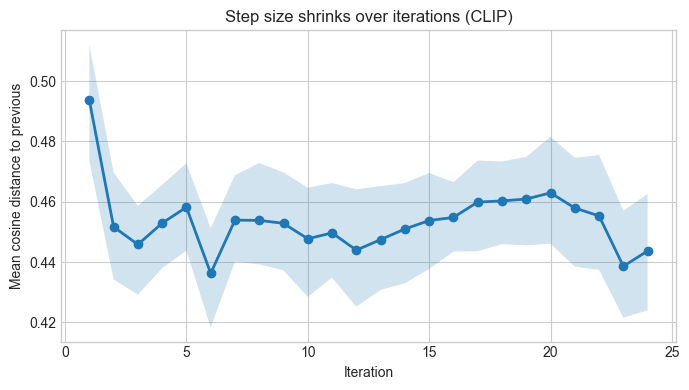

In [173]:
def cosine_distance(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    # embeddings are normalized, so cosine distance is 1 - dot
    return 1.0 - np.sum(a * b, axis=1)


step_means, step_lows, step_highs = [], [], []
step_iters = []
for it in iters[1:]:
    d = cosine_distance(emb_by_iter[it], emb_by_iter[it - 1])
    m, lo, hi = bootstrap_mean_ci(d, n_boot=300, seed=42 + it)
    step_iters.append(it)
    step_means.append(m)
    step_lows.append(lo)
    step_highs.append(hi)

plt.figure(figsize=(7, 4))
plt.plot(step_iters, step_means, marker="o", linewidth=2)
plt.fill_between(step_iters, step_lows, step_highs, alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Mean cosine distance to previous")
plt.title("Step size shrinks over iterations (CLIP)")
plt.tight_layout()
out = FIG_DIR / "fig1_step_size_ci.png"
plt.savefig(out, dpi=300)
out

## Figure 2: drift to original image in CLIP space

This quantifies *how much the image changes* relative to the original, in a standard semantic space.

PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/25_iter_1000_img_1.5/20260107_161610_iter25_img1000/analysis/kmeans/baseline_random_caption_k10_nopca/plots/paper_figures/fig2_drift_to_original_ci.png')

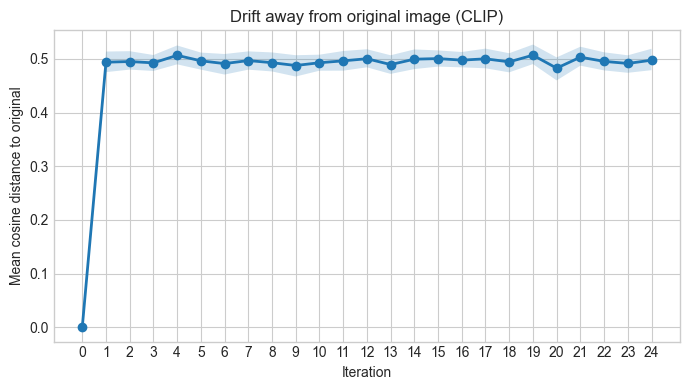

In [174]:
drift_means, drift_lows, drift_highs = [], [], []
for it in iters:
    d = cosine_distance(emb_by_iter[it], emb_by_iter[0])
    m, lo, hi = bootstrap_mean_ci(d, n_boot=300, seed=123 + it)
    drift_means.append(m)
    drift_lows.append(lo)
    drift_highs.append(hi)

plt.figure(figsize=(7, 4))
plt.plot(iters, drift_means, marker="o", linewidth=2)
plt.fill_between(iters, drift_lows, drift_highs, alpha=0.2)
plt.xlabel("Iteration")
plt.xticks(iters)
plt.ylabel("Mean cosine distance to original")
plt.title("Drift away from original image (CLIP)")
plt.tight_layout()
out = FIG_DIR / "fig2_drift_to_original_ci.png"
plt.savefig(out, dpi=300)
out

## Figure 3: basin absorption curve (the “kicker”)

Define **final iteration K-Means centroids** as attractors. Project all iterations into the **same PCA space** (fit on final iteration) and track:
- fraction already in their final basin
- switching rate
- “commitment time”: first iteration when an image enters its final basin and never leaves

This reads like dynamical systems / attractor basin evidence.

(PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/25_iter_1000_img_1.5/20260107_161610_iter25_img1000/analysis/kmeans/baseline_random_caption_k10_nopca/plots/paper_figures/fig3_basin_absorption.png'),
 (0.22, 0.2, 0.18))

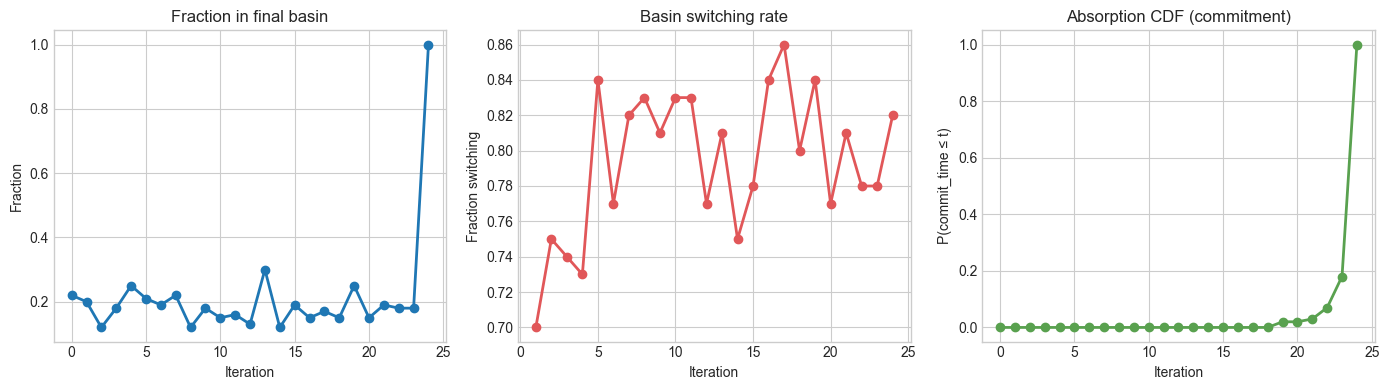

In [175]:
FINAL_IT = max(iters)

# Pull PCA/KMeans config from the main analysis
results = kmeans_obj["results_by_iteration"]
final_itr_str = str(FINAL_IT) if str(FINAL_IT) in results else FINAL_IT
res_final = results[final_itr_str]
centroids_final = np.array(res_final["centroids"])
labels_final = np.array(res_final["labels"])
pca_components = int(kmeans_obj.get("pca_components", centroids_final.shape[1]))
pca_scope = kmeans_obj.get("pca_scope", "global")
apply_pca = kmeans_obj.get("pca_applied", pca_scope != "none" and pca_components > 0)

if centroids_final is None or labels_final is None:
    raise ValueError("Missing centroids/labels in kmeans_analysis.json for final iteration")


def fit_pca_model(emb_by_iter, scope, n_components):
    if not apply_pca or scope == "none" or n_components <= 0:
        return None
    if scope == "global":
        all_emb = np.vstack([emb for emb in emb_by_iter.values()])
        model = PCA(n_components=n_components, random_state=420, whiten=False)
        model.fit(all_emb)
        return model
    # per-iteration scope: reuse the final-iteration PCA so the space matches saved centroids
    model = PCA(n_components=n_components, random_state=420, whiten=False)
    model.fit(emb_by_iter[FINAL_IT])
    return model


def reduce_emb(it, emb, model):
    if model is None or not apply_pca:
        return emb
    return model.transform(emb)


pca_model = fit_pca_model(emb_by_iter, pca_scope, pca_components)
Xf = reduce_emb(FINAL_IT, emb_by_iter[FINAL_IT], pca_model)
centroids = centroids_final
K_ATTRACTORS = centroids.shape[0]

if Xf.shape[1] != centroids.shape[1]:
    raise ValueError(
        f"Dimension mismatch: reduced embeddings have {Xf.shape[1]} dims vs centroids {centroids.shape[1]}"
    )

# Assign all iterations to final centroids (in the same PCA space as the main analysis)
labels_by_iter = {}
for it in iters:
    Xt = reduce_emb(it, emb_by_iter[it], pca_model)     # [N, pca_dim]
    d = np.linalg.norm(Xt[:, None, :] - centroids[None, :, :], axis=-1) # [N, K]
    labels_by_iter[it] = d.argmin(axis=1)   # pick closest centroid for each image

match_final = [(labels_by_iter[it] == labels_final).mean() for it in iters]
switch_rate = [np.nan] + [(labels_by_iter[it] != labels_by_iter[it - 1]).mean() for it in iters[1:]]

# commitment time (absorbing basin time)
n = len(labels_final)
commit_time = np.full(n, -1, dtype=int)
for i in range(n):
    lf = labels_final[i]
    for t in iters:
        if all(labels_by_iter[tt][i] == lf for tt in iters if tt >= t):
            commit_time[i] = t
            break

valid = commit_time >= 0
commit_cdf = [(commit_time[valid] <= t).mean() for t in iters]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(iters, match_final, marker="o", linewidth=2)
axes[0].set_title("Fraction in final basin")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Fraction")

axes[1].plot(iters, switch_rate, marker="o", linewidth=2, color="#E15759")
axes[1].set_title("Basin switching rate")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Fraction switching")

axes[2].plot(iters, commit_cdf, marker="o", linewidth=2, color="#59A14F")
axes[2].set_title("Absorption CDF (commitment)")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("P(commit_time ≤ t)")

plt.tight_layout()
out = FIG_DIR / "fig3_basin_absorption.png"
plt.savefig(out, dpi=300)
out, (match_final[0], match_final[1], match_final[-2])


In [176]:
K_ATTRACTORS

10

## Figure 4: within vs between basin distances

Using **final basin labels** (fixed), compute within-basin and between-basin mean cosine distances over time.

A clean claim: within-basin distances shrink faster than between-basin distances, so basin separation becomes more pronounced.

(PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/25_iter_1000_img_1.5/20260107_161610_iter25_img1000/analysis/kmeans/baseline_random_caption_k10_nopca/plots/paper_figures/fig4_within_between.png'),
 (0.5222091674804688,
  0.3995214104652405,
  0.5094072818756104,
  0.4651567339897156))

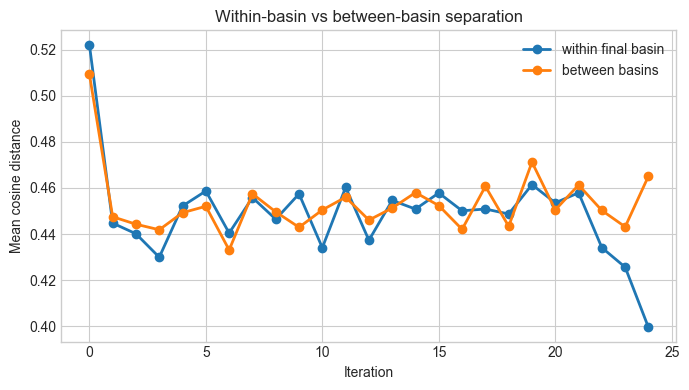

In [177]:
def within_between_means(E: np.ndarray, labels: np.ndarray):
    # cosine dist = 1 - dot; use upper triangle
    sim = E @ E.T
    dist = 1.0 - sim
    iu = np.triu_indices_from(dist, k=1)
    dist_u = dist[iu]
    same = (labels[iu[0]] == labels[iu[1]])
    within = dist_u[same]
    between = dist_u[~same]
    return float(within.mean()), float(between.mean())


within_means, between_means = [], []
for it in iters:
    Et = reduce_emb(it, emb_by_iter[it], pca_model)
    w, b = within_between_means(Et, labels_final)
    within_means.append(w)
    between_means.append(b)

plt.figure(figsize=(7, 4))
plt.plot(iters, within_means, marker="o", linewidth=2, label="within final basin")
plt.plot(iters, between_means, marker="o", linewidth=2, label="between basins")
plt.xlabel("Iteration")
plt.ylabel("Mean cosine distance")
plt.title("Within-basin vs between-basin separation")
plt.legend()
plt.tight_layout()
out = FIG_DIR / "fig4_within_between.png"
plt.savefig(out, dpi=300)
out, (within_means[0], within_means[-1], between_means[0], between_means[-1])


In [178]:
# res_final['labe

In [179]:
emb_by_iter[24].shape

(100, 768)

## Figure 5: attractor prototypes (representative images)

For each final basin, show the 2 nearest images to the centroid (in final PCA space).

This gives you a **visually compelling “attractor gallery”** for a paper slide/figure.

PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/25_iter_1000_img_1.5/20260107_161610_iter25_img1000/analysis/kmeans/baseline_random_caption_k10_nopca/plots/paper_figures/fig5_attractor_gallery_iter9.png')

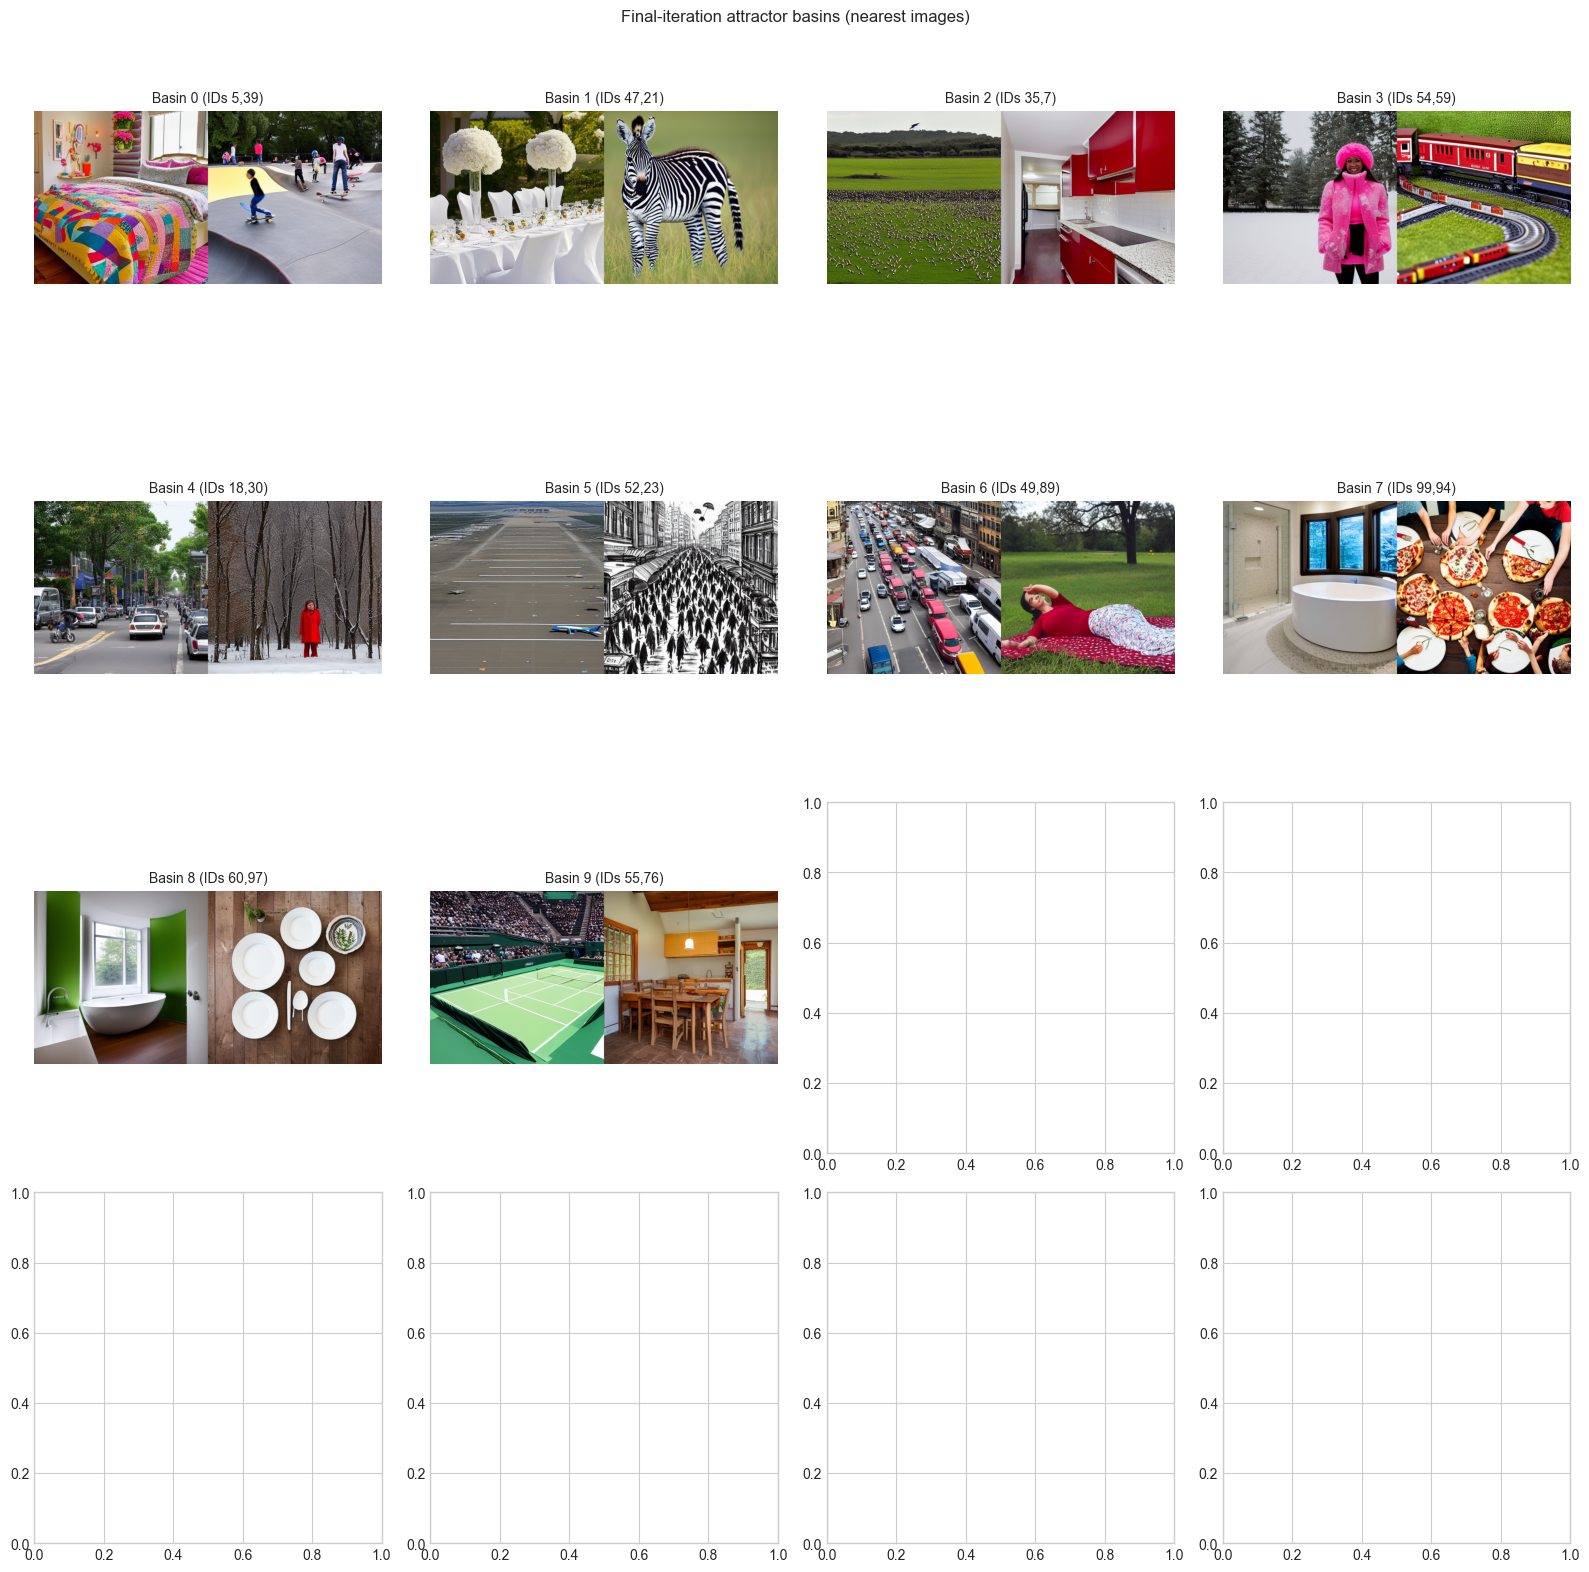

In [180]:
def img_path(image_id: int, iteration: int) -> Path:
    # original saved at iter0 with suffix _original
    if iteration == 0:
        return IMAGES_DIR / f"{RUN_DIR.name}_img{image_id:03d}_iter0_original.png"
    return IMAGES_DIR / f"{RUN_DIR.name}_img{image_id:03d}_iter{iteration}_generated.png"


def hconcat(img_a: Image.Image, img_b: Image.Image) -> Image.Image:
    # resize to same height
    h = min(img_a.size[1], img_b.size[1])
    img_a = img_a.resize((int(img_a.size[0] * h / img_a.size[1]), h))
    img_b = img_b.resize((int(img_b.size[0] * h / img_b.size[1]), h))
    out = Image.new("RGB", (img_a.size[0] + img_b.size[0], h))
    out.paste(img_a, (0, 0))
    out.paste(img_b, (img_a.size[0], 0))
    return out


# nearest-to-centroid in final PCA space
d_to_centroid = np.linalg.norm(Xf[:, None, :] - centroids[None, :, :], axis=-1)
nearest_indices = {c: np.argsort(d_to_centroid[:, c])[:2] for c in range(K_ATTRACTORS)}

rep_imgs = []
rep_titles = []
for c in range(K_ATTRACTORS):
    idx_a, idx_b = nearest_indices[c]
    id_a = int(image_ids[idx_a])
    id_b = int(image_ids[idx_b])
    a = Image.open(img_path(id_a, FINAL_IT)).convert("RGB")
    b = Image.open(img_path(id_b, FINAL_IT)).convert("RGB")
    rep_imgs.append(hconcat(a, b))
    rep_titles.append(f"Basin {c} (IDs {id_a},{id_b})")

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()
for ax, im, title in zip(axes, rep_imgs, rep_titles):
    ax.imshow(im)
    ax.set_title(title, fontsize=10)
    ax.axis("off")
plt.suptitle("Final-iteration attractor basins (nearest images)")
plt.tight_layout()
out = FIG_DIR / "fig5_attractor_gallery_iter9.png"
plt.savefig(out, dpi=250)
out

In [181]:
K_ATTRACTORS

10

## Figure 6: basin-specific information retention

Join final basin labels to your CSV metrics and show that some basins lose caption-information faster than others.

This is an easy story to tell: attractors differ not only semantically, but also in how much they preserve original caption semantics.

In [182]:
# build mapping image_id -> final basin
basin_map = pd.DataFrame({"image_id": image_ids.astype(int), "basin": labels_final.astype(int)})

# final-iteration row per image
final_df = df[df["iteration"] == FINAL_IT].copy()
final_df = final_df.merge(basin_map, on="image_id", how="inner")

# per-image slope of similarity_to_original from iter1..final
pivot = df.pivot(index="image_id", columns="iteration", values="similarity_to_original")
xs = np.arange(1, FINAL_IT + 1, dtype=float)
slopes = {}
for image_id, row in pivot.iterrows():
    ys = row.loc[1:FINAL_IT].values.astype(float)
    if np.any(~np.isfinite(ys)):
        continue
    slope = np.cov(xs, ys, bias=True)[0, 1] / np.var(xs)
    slopes[int(image_id)] = float(slope)

slopes_df = pd.DataFrame({"image_id": list(slopes.keys()), "sim_slope": list(slopes.values())})
final_df = final_df.merge(slopes_df, on="image_id", how="left")

basin_stats = final_df.groupby("basin").agg(
    n=("image_id", "count"),
    sim_final_mean=("similarity_to_original", "mean"),
    sim_final_std=("similarity_to_original", "std"),
    sim_slope_mean=("sim_slope", "mean"),
    bert_mean=("bert_f1", "mean"),
    jacc_mean=("jaccard", "mean"),
).reset_index().sort_values("n", ascending=False)

basin_stats

,basin,n,sim_final_mean,sim_final_std,sim_slope_mean,bert_mean,jacc_mean
6,6,30,0.581389,0.152597,-0.008239,0.893106,0.245335
1,1,17,0.538287,0.185524,-0.011027,0.895973,0.240345
3,3,14,0.557488,0.193595,-0.009267,0.894796,0.213122
4,4,9,0.644132,0.178557,-0.008331,0.893096,0.265147
2,2,7,0.664975,0.141294,-0.008183,0.901560,0.280754
7,7,7,0.575869,0.193527,-0.010971,0.896420,0.263828
9,9,6,0.571654,0.176185,-0.009975,0.887289,0.223852
8,8,4,0.708143,0.152186,-0.003806,0.904581,0.333449
0,0,3,0.606298,0.058709,-0.004895,0.882490,0.179450
5,5,3,0.653700,0.105172,-0.006203,0.895425,0.257521


PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/25_iter_1000_img_1.5/20260107_161610_iter25_img1000/analysis/kmeans/baseline_random_caption_k10_nopca/plots/paper_figures/fig6_basin_retention.png')

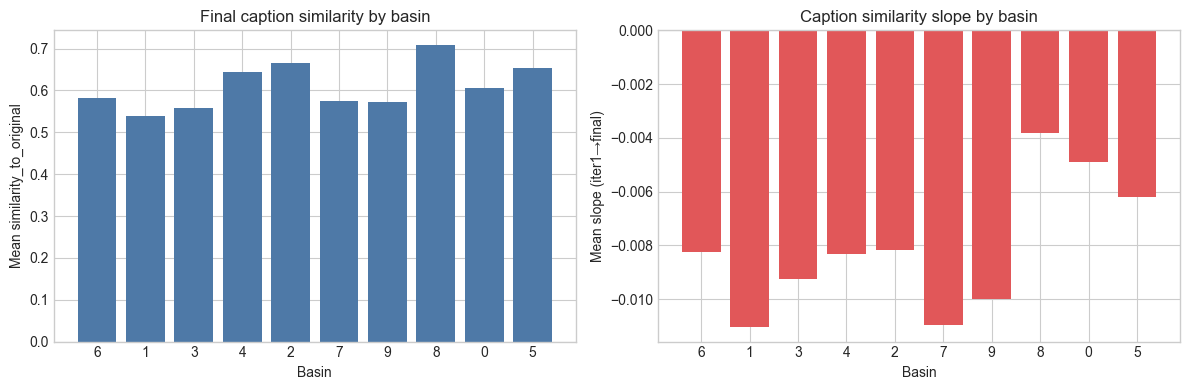

In [183]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(basin_stats["basin"].astype(str), basin_stats["sim_final_mean"], color="#4E79A7")
axes[0].set_title("Final caption similarity by basin")
axes[0].set_xlabel("Basin")
axes[0].set_ylabel("Mean similarity_to_original")

axes[1].bar(basin_stats["basin"].astype(str), basin_stats["sim_slope_mean"], color="#E15759")
axes[1].set_title("Caption similarity slope by basin")
axes[1].set_xlabel("Basin")
axes[1].set_ylabel("Mean slope (iter1→final)")

plt.tight_layout()
out = FIG_DIR / "fig6_basin_retention.png"
plt.savefig(out, dpi=300)
out

## Optional: caption keywords per basin

This helps you *name* the attractors in a paper figure (e.g., “traffic jam”, “beach crowd”, “indoor room”).

It’s a quick, dependency-free approach: tokenize captions, remove stopwords, and print the top words per basin.

In [184]:
import re
from collections import Counter

STOPWORDS = {
    "a","an","the","and","or","of","to","in","on","with","for","at","by","from","as","is","are","was","were",
    "this","that","it","its","their","there","these","those","image","depicts","features","shows","scene","view",
    "one","two","three","several","many","near","visible","can","seen","also","appears","appearing"
}

def top_words(texts, n=12):
    tokens = []
    for t in texts:
        if not isinstance(t, str):
            continue
        ws = re.findall(r"[a-zA-Z']+", t.lower())
        ws = [w for w in ws if w not in STOPWORDS and len(w) >= 3]
        tokens.extend(ws)
    return Counter(tokens).most_common(n)

caption_words = (
    final_df.groupby("basin")["caption"]
    .apply(lambda s: top_words(s.tolist(), n=12))
    .to_dict()
)

for basin, words in sorted(caption_words.items()):
    print(f"Basin {basin}: {[w for (w, _) in words]}")

Basin 0: ['bed', 'doughnuts', 'some', 'park', 'large', 'room', 'table', 'least', 'others', 'people', 'skateboards', 'cozy']
Basin 1: ['people', 'some', 'others', 'large', 'closer', 'positioned', 'table', 'room', 'crowd', 'field', 'white', 'bowl']
Basin 2: ['beach', 'apples', 'umbrellas', 'birds', 'scattered', 'some', 'others', 'across', 'large', 'countertop', 'variety', 'field']
Basin 3: ['some', 'trees', 'others', 'positioned', 'white', 'people', 'walking', 'street', 'snowy', 'snow', 'woman', 'tennis']
Basin 4: ['room', 'bed', 'street', 'people', 'large', 'filled', 'various', 'center', 'atmosphere', 'situated', 'covered', 'busy']
Basin 5: ['various', 'street', 'airplanes', 'black', 'cat', 'bookshelf', 'filled', 'creating', 'atmosphere', 'people', 'some', 'each']
Basin 6: ['table', 'some', 'people', 'street', 'others', 'closer', 'filled', 'large', 'group', 'placed', 'further', 'dining']
Basin 7: ['large', 'some', 'donuts', 'table', 'placed', 'bathroom', 'people', 'sheep', 'which', 'oth

## Suggested paper packaging (minimal, high-impact)

**Figure 1 (Dynamics)**: `fig1_step_size_ci.png` + `fig2_drift_to_original_ci.png`.
- Caption idea: *“Iterative V→L→V acts as a contraction: step sizes shrink and images drift away from the original primarily in the first iteration (projection onto the diffusion manifold).”*

**Figure 2 (Kicker / Attractors)**: `fig3_basin_absorption.png`.
- Caption idea: *“Final-iteration centroids define attractor basins; images enter and remain in their terminal basin quickly (absorption curve).”*

**Figure 3 (What are the attractors?)**: `fig5_attractor_gallery_iter9.png`.
- Caption idea: *“Attractor basins correspond to a small set of semantically coherent archetypes (examples shown).”*

**Figure 4 (Optional, strengthens story)**: `fig6_basin_retention.png`.
- Caption idea: *“Different basins preserve source-caption semantics to different degrees.”*

If you only have time for **one “big kicker” slide**, show Figure 2 + Figure 3 together.

## Paper-ready summary numbers (copy/paste)

Use these as “headline” results in your abstract/slide:
- contraction in CLIP space (pairwise distance, drift)
- absorption curve milestones (e.g. % in final basin at iter1, iter8)
- convergence rate from `scripts/analyze_attractors.py` (VLM vision embedding fixed points)


In [146]:
pairwise0 = float(kmeans_obj["results_by_iteration"]["0"]["pairwise_mean"])
pairwise9 = float(kmeans_obj["results_by_iteration"][str(FINAL_IT)]["pairwise_mean"])
sil0 = float(kmeans_obj["results_by_iteration"]["0"]["best_silhouette"])
sil9 = float(kmeans_obj["results_by_iteration"][str(FINAL_IT)]["best_silhouette"])

print("CLIP pairwise mean distance:", f"{pairwise0:.4f} → {pairwise9:.4f}", f"({(pairwise9-pairwise0)/pairwise0*100:+.1f}%)")
print("Silhouette (chosen k):", f"{sil0:.4f} → {sil9:.4f}", f"({(sil9-sil0)/sil0*100:+.1f}%)")
print("Basin match-final fraction:")
print("  iter0:", f"{match_final[0]*100:.1f}%")
print("  iter1:", f"{match_final[1]*100:.1f}%")
print("  iter8:", f"{match_final[-2]*100:.1f}%")

print("Commitment CDF:")
for t in [0, 3, 8, 13, 18, 23]:
    print(f"  P(commit_time ≤ {t}): {commit_cdf[t]*100:.1f}%")


CLIP pairwise mean distance: 1.0070 → 0.9432 (-6.3%)
Silhouette (chosen k): 0.0613 → 0.0794 (+29.6%)
Basin match-final fraction:
  iter0: 81.0%
  iter1: 91.0%
  iter8: 91.0%
Commitment CDF:
  P(commit_time ≤ 0): 59.0%
  P(commit_time ≤ 3): 67.0%
  P(commit_time ≤ 8): 70.0%
  P(commit_time ≤ 13): 73.0%
  P(commit_time ≤ 18): 77.0%
  P(commit_time ≤ 23): 91.0%


/Users/deancasey/Documents/Columbia/vlm-iterative-loss/info_loss/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


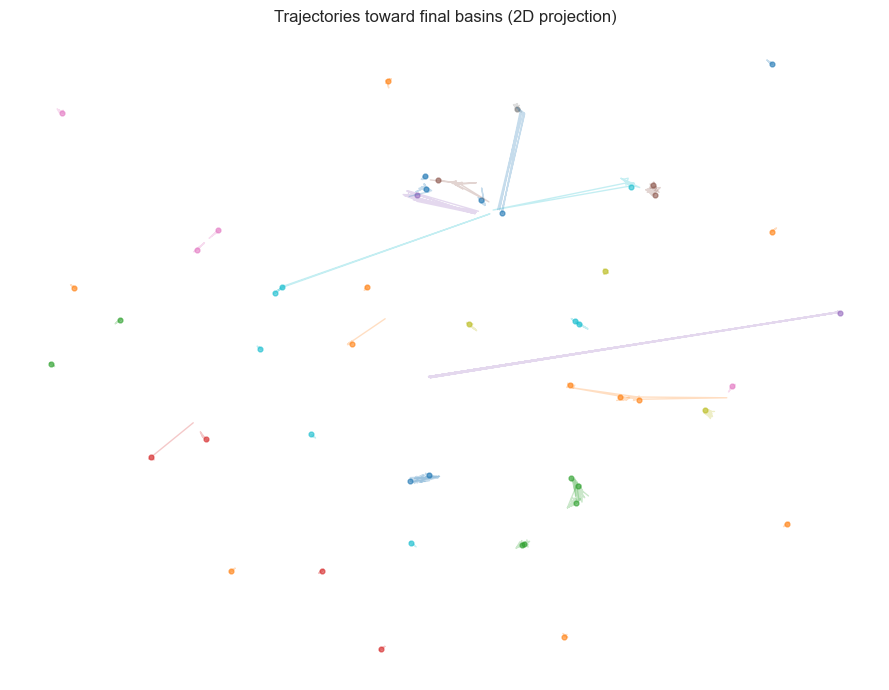

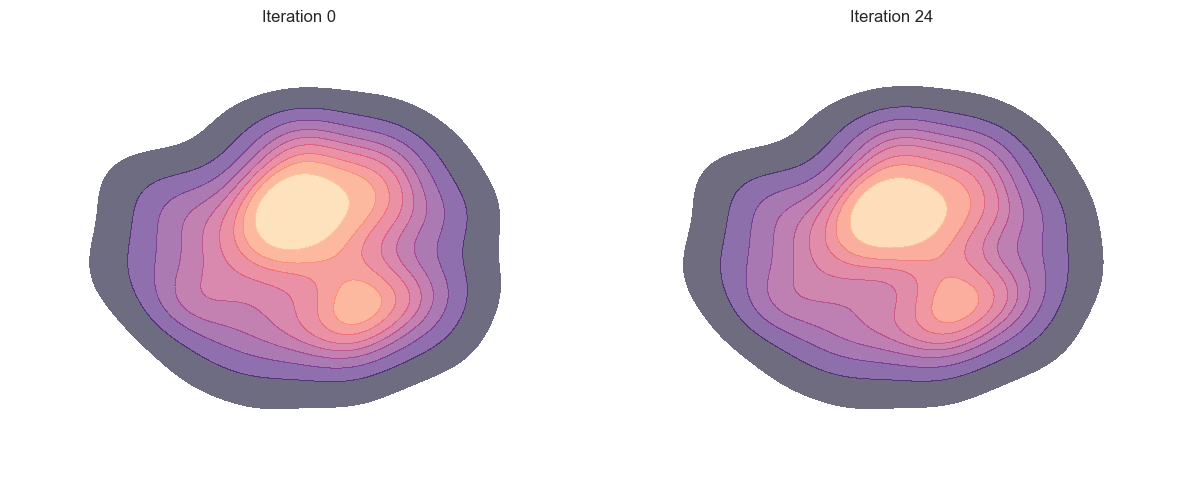

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP  # pip install umap-learn
from sklearn.decomposition import PCA

# ---- Fit projector on concatenated embeddings (or just final iter) ----
all_emb = np.vstack([emb_by_iter[it] for it in iters])  # or emb_by_iter[FINAL_IT]
pca50 = PCA(n_components=50, random_state=420).fit(all_emb)
umap2 = UMAP(n_components=2, random_state=420, metric="cosine").fit(pca50.transform(all_emb))
# umap2 = UMAP(n_components=2, random_state=420, metric="cosine").fit(all_emb)


# ---- Project each iteration ----
proj_by_iter = {}
for it in iters:
    proj_by_iter[it] = umap2.transform(pca50.transform(emb_by_iter[it]))

# ---- Basin labels (final) ----
labels_final = labels_by_iter[FINAL_IT]  # from the basin assignment step

# ---- Sample a subset for trajectories ----
rng = np.random.default_rng(0)
idx = rng.choice(len(labels_final), size=min(50, len(labels_final)), replace=False)

plt.figure(figsize=(9, 7))
for i in idx:
    xs = [proj_by_iter[it][i, 0] for it in iters]
    ys = [proj_by_iter[it][i, 1] for it in iters]
    c = plt.cm.tab10(labels_final[i] % 10)
    plt.plot(xs, ys, '-', color=c, alpha=0.25, linewidth=1)
    plt.scatter(xs[-1], ys[-1], color=c, s=12, alpha=0.6)

plt.title("Trajectories toward final basins (2D projection)")
plt.axis('off')
plt.tight_layout()
plt.savefig(FIG_DIR / "traj_umap.png", dpi=300)
plt.show()

# ---- KDE contours per iteration (global density) ----
fig, axes = plt.subplots(1, 2, figsize=(12,5))
for ax, it in zip(axes, [0, FINAL_IT]):
    xy = proj_by_iter[it]
    sns.kdeplot(x=xy[:,0], y=xy[:,1], fill=True, levels=10, cmap="magma", alpha=0.6, ax=ax)
    ax.set_title(f"Iteration {it}")
    ax.axis('off')
plt.tight_layout()
plt.savefig(FIG_DIR / "kde_iter0_vs_final.png", dpi=300)
plt.show()

## Baselines vs main pipeline (2x2 metrics)

Closed-loop VLM+SD vs all baselines, reusing saved CLIP embeddings and KMeans analyses. This builds a 4-panel figure (step size, drift, cluster separation, basin switching) and saves it to `analysis/kmeans/plots/baseline_vs_main/vlm_vs_baselines_metrics_2x2.png`. The main KMeans file is auto-picked as the newest non-baseline folder under `analysis/kmeans`; update `MAIN_KMEANS` if you want a different one.

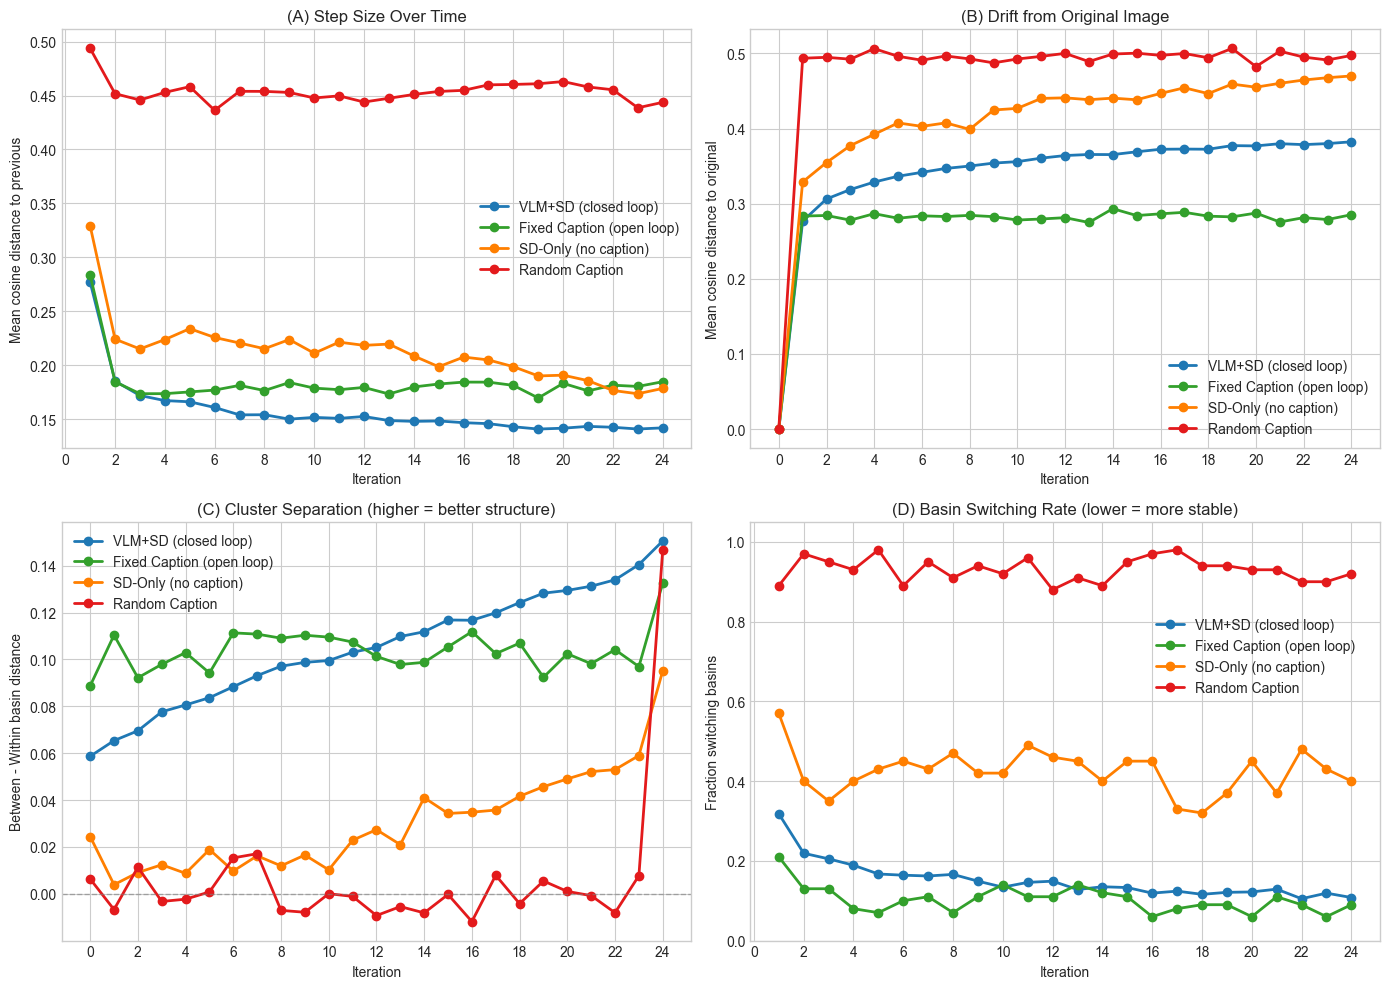

In [188]:
# Full comparison across baselines vs main pipeline (step size, drift, separation, switching, silhouette)

def latest_main_kmeans(root: Path) -> Path:
    candidates = sorted(
        [p for p in root.glob("*") if p.is_dir() and not p.name.startswith("baseline_")],
        key=lambda p: p.stat().st_mtime,
    )
    if not candidates:
        raise FileNotFoundError(f"No non-baseline analysis dirs found in {root}")
    return candidates[-1] / "kmeans_analysis.json"

BASELINE_KMEANS = {
    "fixed_caption": ANALYSIS_ROOT / "baseline_fixed_caption_k25_nopca" / "kmeans_analysis.json",
    "sd_only": ANALYSIS_ROOT / "baseline_sd_only_k25_nopca" / "kmeans_analysis.json",
    "random_caption": ANALYSIS_ROOT / "baseline_random_caption_k25_nopca" / "kmeans_analysis.json",
}
MAIN_KMEANS_DIR = RUN_DIR / "analysis/kmeans/20260111_092718_k25_nopca"  # change this to any other run
MAIN_KMEANS = MAIN_KMEANS_DIR / "kmeans_analysis.json"

for path in [MAIN_KMEANS, *BASELINE_KMEANS.values()]:
    if not path.exists():
        raise FileNotFoundError(f"Missing kmeans_analysis.json: {path}")

palette = {
    "vlm_sd": "#1f78b4",
    "fixed_caption": "#33a02c",
    "sd_only": "#ff7f00",
    "random_caption": "#e31a1c",
}

USE_FINAL_CENTROIDS = True  # Toggle: True = anchor to final iteration, False = per-iteration labels/centroids

run_specs = [
    {
        "key": "vlm_sd",
        "label": "VLM+SD (closed loop)",
        "color": palette["vlm_sd"],
        "loader": lambda: load_all_checkpoints(RUN_DIR),
        "kmeans_json": MAIN_KMEANS,
    },
    {
        "key": "fixed_caption",
        "label": "Fixed Caption (open loop)",
        "color": palette["fixed_caption"],
        "loader": lambda: load_baseline_embeddings(BASELINE_NPZ, "fixed_caption"),
        "kmeans_json": BASELINE_KMEANS["fixed_caption"],
    },
    {
        "key": "sd_only",
        "label": "SD-Only (no caption)",
        "color": palette["sd_only"],
        "loader": lambda: load_baseline_embeddings(BASELINE_NPZ, "sd_only"),
        "kmeans_json": BASELINE_KMEANS["sd_only"],
    },
    {
        "key": "random_caption",
        "label": "Random Caption",
        "color": palette["random_caption"],
        "loader": lambda: load_baseline_embeddings(BASELINE_NPZ, "random_caption"),
        "kmeans_json": BASELINE_KMEANS["random_caption"],
    },
]

comparison_dir = RUN_DIR / "analysis/kmeans/plots/baseline_vs_main"
comparison_dir.mkdir(parents=True, exist_ok=True)

def mean_within_between_fast(E, labels):
    E = np.asarray(E, dtype=np.float64)
    labels = np.asarray(labels)
    norms = np.linalg.norm(E, axis=1, keepdims=True)
    E = E / np.clip(norms, 1e-9, None)
    uniq = np.unique(labels)
    sums = [E[labels == u].sum(axis=0) for u in uniq]
    counts = [(labels == u).sum() for u in uniq]
    within_pairs = sum(c * (c - 1) / 2 for c in counts)
    between_pairs = 0
    within_dot = 0.0
    between_dot = 0.0
    for s, c in zip(sums, counts):
        if c > 1:
            within_dot += (float(np.dot(s, s)) - c) / 2.0
    for i in range(len(uniq)):
        for j in range(i + 1, len(uniq)):
            between_dot += float(np.dot(sums[i], sums[j]))
            between_pairs += counts[i] * counts[j]
    within_mean = 1.0 - (within_dot / within_pairs) if within_pairs > 0 else np.nan
    between_mean = 1.0 - (between_dot / between_pairs) if between_pairs > 0 else np.nan
    return within_mean, between_mean


def compute_run_metrics(emb_by_iter, kmeans_json: Path):
    with open(kmeans_json, "r", encoding="utf-8") as f:
        kmeans_obj = json.load(f)

    iters = sorted(int(i) for i in emb_by_iter.keys())
    final_it = max(iters)

    results = kmeans_obj["results_by_iteration"]
    silhouette_scores = []
    for it in iters:
        iter_res = results.get(str(it), results.get(it, {}))
        sil = iter_res.get("best_silhouette") if iter_res is not None else None
        silhouette_scores.append(float(sil) if sil is not None else np.nan)

    final_key = str(final_it) if str(final_it) in results else final_it
    res_final = results[final_key]
    centroids_final = np.array(res_final["centroids"], dtype=float)
    labels_final = np.array(res_final["labels"])

    pca_components = int(kmeans_obj.get("pca_components", centroids_final.shape[1]))
    pca_scope = kmeans_obj.get("pca_scope", "none")
    apply_pca = kmeans_obj.get("pca_applied", pca_scope != "none" and pca_components > 0)
    use_final = USE_FINAL_CENTROIDS

    def fit_pca_model():
        if not apply_pca:
            return None
        model = PCA(n_components=pca_components, random_state=420, whiten=False)
        if pca_scope == "global":
            model.fit(np.vstack([emb for emb in emb_by_iter.values()]))
        else:
            model.fit(emb_by_iter[final_it])
        return model

    pca_model = fit_pca_model()

    def reduce_emb(it, emb):
        return emb if pca_model is None else pca_model.transform(emb)

    step_iters, step_means = [], []
    for it in iters[1:]:
        d = cosine_distance(emb_by_iter[it], emb_by_iter[it - 1])
        step_iters.append(it)
        step_means.append(float(d.mean()))

    drift_means = [float(cosine_distance(emb_by_iter[it], emb_by_iter[iters[0]]).mean()) for it in iters]

    labels_by_iter = {}
    for it in iters:
        Xt = reduce_emb(it, emb_by_iter[it])
        iter_res = results.get(str(it), results.get(it, {}))
        if use_final:
            dists = np.linalg.norm(Xt[:, None, :] - centroids_final[None, :, :], axis=-1)
            labels_by_iter[it] = dists.argmin(axis=1)
        else:
            lbls = np.array(iter_res.get("labels")) if iter_res is not None else None
            if lbls is None or len(lbls) != len(Xt):
                labels_by_iter[it] = np.full(len(Xt), fill_value=-1, dtype=int)
            else:
                labels_by_iter[it] = lbls

    switch_rate = [np.nan] + [
        (labels_by_iter[it] != labels_by_iter[it - 1]).mean() for it in iters[1:]
    ]

    within_means, between_means = [], []
    for it in iters:
        Xt = reduce_emb(it, emb_by_iter[it])
        labels_ref = labels_final if use_final else labels_by_iter[it]
        w, b = mean_within_between_fast(Xt, labels_ref)
        within_means.append(w)
        between_means.append(b)

    return {
        "iters": iters,
        "step_iters": step_iters,
        "step": step_means,
        "drift": drift_means,
        "switch": switch_rate,
        "cluster_sep": list(np.array(between_means) - np.array(within_means)),
        "silhouette": silhouette_scores,
    }


comparison_results = []
for spec in run_specs:
    embeds, _ = spec["loader"]()
    metrics = compute_run_metrics(embeds, spec["kmeans_json"])
    spec["metrics"] = metrics
    comparison_results.append(spec)

max_iter = max(spec["metrics"]["iters"][-1] for spec in comparison_results)
xticks = list(range(0, max_iter + 1, 2))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax_step, ax_drift), (ax_sep, ax_switch) = axes

for spec in comparison_results:
    m = spec["metrics"]
    label = spec["label"]
    color = spec["color"]
    ax_step.plot(m["step_iters"], m["step"], marker="o", linewidth=2, color=color, label=label)
    ax_drift.plot(m["iters"], m["drift"], marker="o", linewidth=2, color=color, label=label)
    ax_sep.plot(m["iters"], m["cluster_sep"], marker="o", linewidth=2, color=color, label=label)
    ax_switch.plot(m["iters"], m["switch"], marker="o", linewidth=2, color=color, label=label)

ax_step.set_title("(A) Step Size Over Time")
ax_step.set_xlabel("Iteration")
ax_step.set_ylabel("Mean cosine distance to previous")
ax_step.set_xticks(xticks)

ax_drift.set_title("(B) Drift from Original Image")
ax_drift.set_xlabel("Iteration")
ax_drift.set_ylabel("Mean cosine distance to original")
ax_drift.set_xticks(xticks)

ax_sep.set_title("(C) Cluster Separation (higher = better structure)")
ax_sep.set_xlabel("Iteration")
ax_sep.set_ylabel("Between - Within basin distance")
ax_sep.axhline(0, color="gray", linestyle="--", linewidth=1, alpha=0.6)
ax_sep.set_xticks(xticks)

ax_switch.set_title("(D) Basin Switching Rate (lower = more stable)")
ax_switch.set_xlabel("Iteration")
ax_switch.set_ylabel("Fraction switching basins")
ax_switch.set_xticks(xticks)
ax_switch.set_ylim(0, 1.05)

for ax in [ax_step, ax_drift, ax_sep]:
    ax.legend(loc="best")

# lift the basin-switch legend upward so it clears the SD-only line
ax_switch.legend(loc="upper right", bbox_to_anchor=(0.98, 0.8))


fig.tight_layout()
out_path = comparison_dir / "vlm_vs_baselines_metrics_2x2.png"
fig.savefig(out_path, dpi=300)

# fig_sil, ax_sil = plt.subplots(figsize=(7, 5))
# for spec in comparison_results:
#     m = spec["metrics"]
#     label = spec["label"]
#     color = spec["color"]
#     ax_sil.plot(m["iters"], m["silhouette"], marker="o", linewidth=2, color=color, label=label)

# ax_sil.set_title("(E) Silhouette Score (higher = better quality)")
# ax_sil.set_xlabel("Iteration")
# ax_sil.set_ylabel("Silhouette score")
# ax_sil.set_xticks(xticks)
# ax_sil.set_ylim(-0.2, 1.0)
# ax_sil.legend(loc="best")
# ax_sil.grid(True, alpha=0.3)

# sil_path = comparison_dir / "vlm_vs_baselines_silhouette.png"
# fig_sil.tight_layout()
# fig_sil.savefig(sil_path, dpi=300)
# (out_path, sil_path)



In [36]:
comparison_results[3]['metrics'].keys()

dict_keys(['iters', 'step_iters', 'step', 'drift', 'switch', 'cluster_sep'])

In [32]:
len(comparison_results)

4

In [40]:
comparison_results[3]['metrics']['cluster_sep']

[0.0020682108497325213,
 -0.016675198546932002,
 0.009024859943812524,
 -0.0018848474447608066,
 -0.003936800260358586,
 -0.014414246818836629,
 0.02102262813776734,
 0.02044279443806918,
 -0.007501810128482278,
 -0.014085350815911779,
 -0.017755087112093837,
 -0.005906345594296147,
 -0.0141636634479676,
 0.0074966924182412464,
 -0.007473412879783203,
 0.0046390451810323086,
 -0.008606890164617909,
 0.006465263234856966,
 -0.008470820591840234,
 0.015338184018362733,
 0.008667209069899595,
 0.0012883475858257443,
 -0.009164828693130844,
 0.006503663914012581,
 0.19966220715278704]